In [1]:
!pip install pandas requests beautifulsoup4 tqdm

In [2]:
import pandas as pd
import requests
from urllib.parse import urljoin
from bs4 import BeautifulSoup
import concurrent.futures
import logging
from tqdm import tqdm
import time
import random

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class EthicalSocialMediaChecker:
    def __init__(self):
        self.social_media_patterns = {
            'sm_fb': ['facebook.com', 'fb.com'],
            'sm_linkedin': ['linkedin.com'],
            'sm_x': ['twitter.com', 'x.com'],
            'sm_insta': ['instagram.com'],
            'sm_tiktok': ['tiktok.com'],
            'sm_yt': ['youtube.com']
        }
        # Ethical user agent string
        self.headers = {
            'User-Agent': 'Ethical Web Scraper/1.0 (Educational Project; Contact: roshna.omer@gmail.com)'
        }

    def check_url(self, row):
        url = row['url']
        if not url.startswith(('http://', 'https://')):
            url = 'https://' + url

        try:
            # Random delay between requests (1 to 3 seconds)
            time.sleep(random.uniform(1, 3))

            # First, check for robots.txt
            robots_url = urljoin(url, '/robots.txt')
            try:
                robots_response = requests.get(robots_url, headers=self.headers, timeout=5)
                if 'disallow: /' in robots_response.text.lower():
                    logging.info(f"Respecting robots.txt disallow for {url}")
                    return self.create_empty_result(row)
            except Exception:
                # If we can't check robots.txt, we'll proceed cautiously
                pass

            response = requests.get(url, headers=self.headers, timeout=10)
            soup = BeautifulSoup(response.text, 'html.parser')

            results = {
                'id': row['id'],
                'url': row['url'],
                'country': row['country'],
                'ecommerce': row['ecommerce']
            }

            # Only look for social media links in the footer or header
            potential_sections = soup.find_all(['header', 'footer'])
            links = []
            for section in potential_sections:
                links.extend([a.get('href', '') for a in section.find_all('a', href=True)])

            # Check each social media platform
            for platform, patterns in self.social_media_patterns.items():
                found = 0
                for link in links:
                    if any(pattern in link.lower() for pattern in patterns):
                        found = 1
                        break
                results[platform] = found

            return results

        except Exception as e:
            logging.error(f"Error processing {url}: {str(e)}")
            return self.create_empty_result(row)

    def create_empty_result(self, row):
        return {
            'id': row['id'],
            'url': row['url'],
            'country': row['country'],
            'ecommerce': row['ecommerce'],
            **{platform: 0 for platform in self.social_media_patterns.keys()}
        }

def process_csv(input_file, output_file, max_workers=3):
    # Read the CSV file
    df = pd.read_csv(input_file)

    checker = EthicalSocialMediaChecker()
    results = []

    # Limit the number of concurrent requests
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(checker.check_url, row) for _, row in df.iterrows()]

        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            result = future.result()
            if result:
                results.append(result)

    # Create results DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)
    logging.info(f"Results saved to {output_file}")

if __name__ == "__main__":
    input_file = 'input.csv'
    output_file = 'results.csv'
    process_csv(input_file, output_file)

100%|██████████| 4000/4000 [1:19:26<00:00,  1.19s/it]


In [3]:
!pip install matplotlib

Total websites analyzed: 4000
Websites with no social media: 3327 (83.2%)
Websites with at least one social media: 673 (16.8%)

Distribution of social media platforms per website:
0 platforms: 3327 websites (83.2%)
1 platforms: 116 websites (2.9%)
2 platforms: 262 websites (6.6%)
3 platforms: 161 websites (4.0%)
4 platforms: 90 websites (2.2%)
5 platforms: 39 websites (1.0%)
6 platforms: 5 websites (0.1%)

Popularity of each platform:
sm_fb: 610 websites (15.2%)
sm_linkedin: 207 websites (5.2%)
sm_x: 104 websites (2.6%)
sm_insta: 519 websites (13.0%)
sm_tiktok: 57 websites (1.4%)
sm_yt: 211 websites (5.3%)


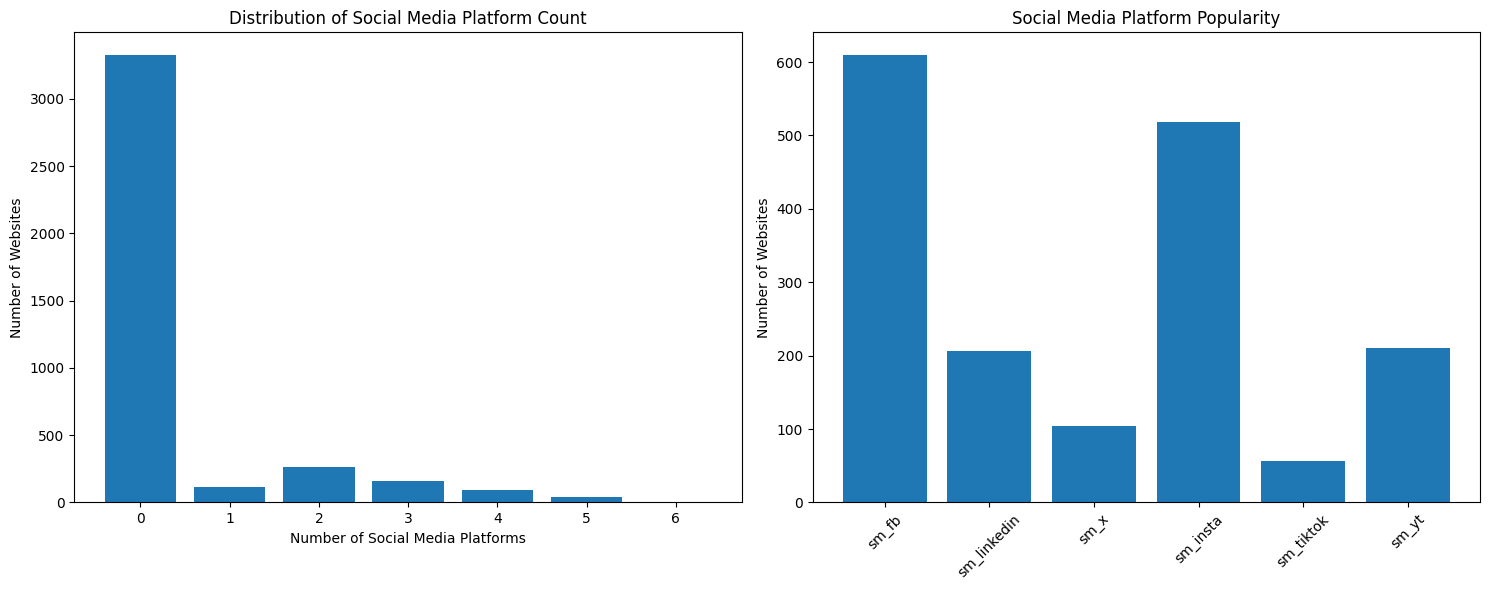

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

def analyze_results(csv_file):
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # List of social media columns
    social_media_cols = ['sm_fb', 'sm_linkedin', 'sm_x', 'sm_insta', 'sm_tiktok', 'sm_yt']

    # Calculate the sum of social media presence for each website
    df['total_sm_count'] = df[social_media_cols].sum(axis=1)

    # Count websites by number of social media platforms
    sm_distribution = Counter(df['total_sm_count'])

    # Calculate total websites
    total_websites = len(df)

    # Calculate websites with no social media
    no_sm = sm_distribution[0]

    # Calculate websites with at least one social media
    has_sm = total_websites - no_sm

    # Create a summary dictionary
    summary = {
        'total_websites': total_websites,
        'no_social_media': no_sm,
        'has_social_media': has_sm,
        'distribution': {i: sm_distribution[i] for i in range(7)},
        'platform_stats': {col: int(df[col].sum()) for col in social_media_cols}
    }

    return df, summary

def print_summary(summary):
    print(f"Total websites analyzed: {summary['total_websites']}")
    print(f"Websites with no social media: {summary['no_social_media']} ({summary['no_social_media']/summary['total_websites']*100:.1f}%)")
    print(f"Websites with at least one social media: {summary['has_social_media']} ({summary['has_social_media']/summary['total_websites']*100:.1f}%)")

    print("\nDistribution of social media platforms per website:")
    for num, count in summary['distribution'].items():
        percentage = count/summary['total_websites']*100
        print(f"{num} platforms: {count} websites ({percentage:.1f}%)")

    print("\nPopularity of each platform:")
    for platform, count in summary['platform_stats'].items():
        percentage = count/summary['total_websites']*100
        print(f"{platform}: {count} websites ({percentage:.1f}%)")

def plot_summary(df, summary):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Distribution of number of social media platforms
    platforms = list(summary['distribution'].keys())
    counts = list(summary['distribution'].values())
    ax1.bar(platforms, counts)
    ax1.set_xlabel('Number of Social Media Platforms')
    ax1.set_ylabel('Number of Websites')
    ax1.set_title('Distribution of Social Media Platform Count')

    # Plot 2: Platform popularity
    platforms = list(summary['platform_stats'].keys())
    counts = list(summary['platform_stats'].values())
    ax2.bar(platforms, counts)
    ax2.set_xticks(range(len(platforms)))
    ax2.set_xticklabels(platforms, rotation=45)
    ax2.set_ylabel('Number of Websites')
    ax2.set_title('Social Media Platform Popularity')

    plt.tight_layout()
    return fig

# Load and analyze data
df, summary = analyze_results('results.csv')

# Print text summary
print_summary(summary)

# Show plots
fig = plot_summary(df, summary)